In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassF1Score


import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

# Read data

In [4]:
data_paths = {
    'train': '/kaggle/input/aiomodule6cassavaleaf/cassavaleafdata/train',
    'valid': '/kaggle/input/aiomodule6cassavaleaf/cassavaleafdata/validation',
    'test' : '/kaggle/input/aiomodule6cassavaleaf/cassavaleafdata/test'
}

# load image from path
def loader(path):
    return Image.open(path)

### class Dataset 

In [5]:
img_size = 224
train_transforms = transforms.Compose([
    transforms.Resize ((img_size, img_size)), # Resize image
    transforms.ToTensor(), # convert to Tensor and normalise to range [0, 1] 
])

train_dataset = datasets.ImageFolder(
    root = data_paths['train'],
    loader = loader,
    transform = train_transforms
)

val_dataset = datasets.ImageFolder(
    root = data_paths['valid'],
    transform = train_transforms
)

test_dataset = datasets.ImageFolder(
    root = data_paths['test'],
    transform = train_transforms
)

print("Class names:", train_dataset.classes)
print("Class to index mapping:", train_dataset.class_to_idx)
print("Number of classes:", len(train_dataset.classes))

Class names: ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
Class to index mapping: {'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}
Number of classes: 5


In [6]:
loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=2)

# Accumulate sum and squared sum
mean = 0.0
std = 0.0
nb_samples = 0.0

for data, _ in tqdm(loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 23/23 [00:31<00:00,  1.39s/it]

Mean: tensor([0.4479, 0.4966, 0.3222])
Std: tensor([0.1918, 0.1923, 0.1654])


In [7]:
additional_train_transform = transforms.Compose([
    transforms.Resize ((img_size, img_size)), # Resize image
    transforms.ToTensor(), # convert to Tensor and normalise to range [0, 1] 
    transforms.Normalize(mean.tolist(), std.tolist())
    # transforms.RandomCrop(img_size, padding = 5),
    # transforms.RandomErasing(
    #     p = 0.75,
    #     scale = (0.01, 0.3),
    #     ratio = (1.0, 1.0),
    #     value = 0,
    #     inplace = True
    # ),
    # transforms.RandomHorizontalFlip(p = 0.5),
])

additional_val_transform = transforms.Compose([
    transforms.Resize ((img_size, img_size)), # Resize image
    transforms.ToTensor(), # convert to Tensor and normalise to range [0, 1] 
    transforms.Normalize(mean.tolist(), std.tolist())
])

train_dataset.transform = additional_train_transform
test_dataset.transform = additional_val_transform
val_dataset.transform = additional_val_transform

In [8]:
# Get one sample from each dataset
train_img, train_label = train_dataset[0]
val_img, val_label = val_dataset[0]
test_img, test_label = test_dataset[0]

print("Number of train samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

# Print shapes
print("Train image shape:", train_img.shape)
print("Validation image shape:", val_img.shape)
print("Test image shape:", test_img.shape)

Number of train samples: 5656
Number of validation samples: 1889
Number of test samples: 1885
Train image shape: torch.Size([3, 224, 224])
Validation image shape: torch.Size([3, 224, 224])
Test image shape: torch.Size([3, 224, 224])


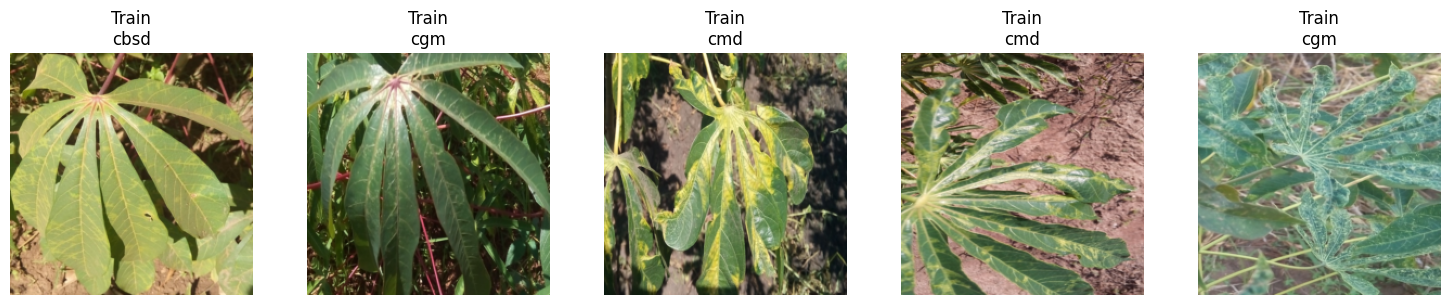

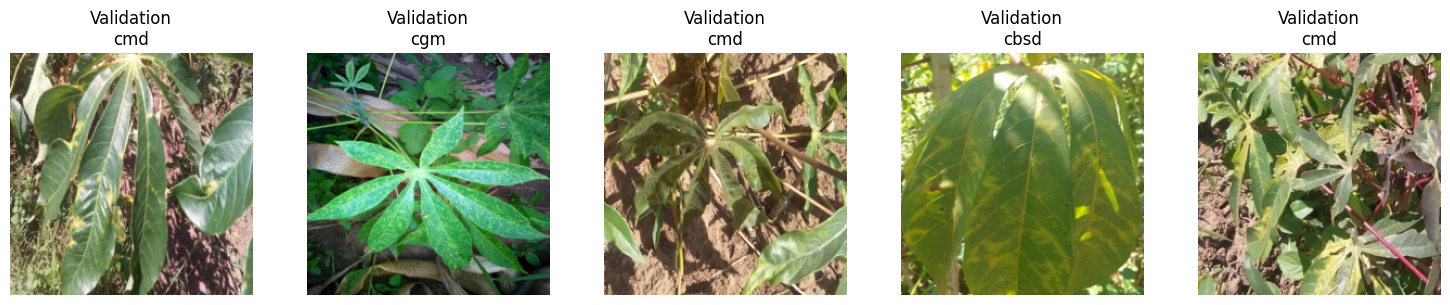

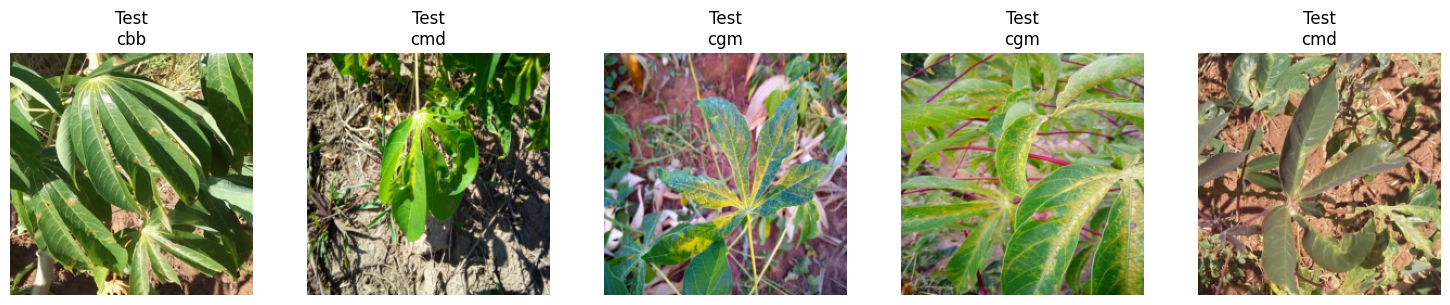

In [9]:
import matplotlib.pyplot as plt
import random

# Helper to denormalize for visualization
def denormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# Helper to plot images from a dataset
def show_random_images(dataset, dataset_name, mean, std, num_images=5):
    indices = random.sample(range(len(dataset)), num_images)
    class_names = dataset.classes

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = denormalize(img, mean, std)  # undo normalization
        img = img.permute(1, 2, 0).numpy()  # CxHxW → HxWxC

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{dataset_name}\n{class_names[label]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Show images from each dataset
show_random_images(train_dataset, "Train", mean, std)
show_random_images(val_dataset, "Validation", mean, std)
show_random_images(test_dataset, "Test", mean, std)


In [10]:
batch = 768

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch,
    shuffle = False
)

val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = batch,
    shuffle = False
)

In [11]:
# Print shape of one batch from each loader
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))
test_images, test_labels = next(iter(test_loader))

print("Train batch - images shape:", train_images.shape)
print("Train batch - labels shape:", train_labels.shape)

print("Validation batch - images shape:", val_images.shape)
print("Validation batch - labels shape:", val_labels.shape)

print("Test batch - images shape:", test_images.shape)
print("Test batch - labels shape:", test_labels.shape)

Train batch - images shape: torch.Size([768, 3, 224, 224])
Train batch - labels shape: torch.Size([768])
Validation batch - images shape: torch.Size([768, 3, 224, 224])
Validation batch - labels shape: torch.Size([768])
Test batch - images shape: torch.Size([768, 3, 224, 224])
Test batch - labels shape: torch.Size([768])


# Build Model

In [12]:
import torch
import torch.nn as nn

class PatchPositionEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, img_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = embed_dim, kernel_size = patch_size, stride = patch_size, bias = False)

        scale = embed_dim ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(embed_dim))
        self.positional_embedding = nn.Embedding(num_embeddings= (img_size // patch_size) ** 2 + 1, embedding_dim= embed_dim) 
        # return lookup table

    def forward(self, X):
        device = X.device
        
        X = self.conv1(X) # shape: [B, C, W, H]
        X = X.reshape(X.shape[0], X.shape[1], -1) #[B, C, W*H]
        X = X.permute(0, 2, 1) #[B, W*H, C] = [B, L, D]
        # Expand class_embedding
        cls_embs =self.class_embedding.unsqueeze(0).unsqueeze(1).expand(X.shape[0], 1, -1)
        X = torch.cat([cls_embs, X], dim = 1) # [B, L + 1, D]
        pos_l = torch.arange(X.shape[1]).to(device)
        pos_embed = self.positional_embedding(pos_l)
        X = X + pos_embed

        return X


In [13]:
class transformer_layer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim = embed_dim, 
                                          num_heads = num_heads,
                                         batch_first = True)
        self.ffn = nn.Sequential (
                nn.Linear( in_features = embed_dim , out_features = ff_dim , bias = True ) ,
                nn.LeakyReLU(0.1) ,
                nn.Linear( in_features = ff_dim , out_features = embed_dim , bias = True )
        )
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, Q, K, V):
        attn_output , _ = self.attn(Q, K, V)
        attn_output = self.dropout(attn_output)
        out_1 = self.layer_norm_1(Q + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout(ffn_output)
        out_2 = self.layer_norm_2(out_1 + ffn_output)
        return out_2

In [14]:
class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, 
                dropout =0.1, num_classes = 10, patch_size = 16):
        super().__init__()
        self.embed_layer = PatchPositionEmbedding(
            img_size = image_size, embed_dim = embed_dim, patch_size = patch_size
        )
        self.transformer_layer = transformer_layer(
            embed_dim, num_heads, ff_dim
        )
    
        self.classifier = nn.Sequential(
            nn.Linear(in_features = embed_dim, out_features = 20),
            nn.LeakyReLU(0.1),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = 20, out_features = num_classes),
        )

    def forward(self, X):
        output = self.embed_layer(X)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :] # get only first L
        output = self.classifier(output)
        return output

In [15]:
hyperparameter = {
    "num_classes": len(train_dataset.classes),
    "image_size": img_size, 
    "patch_size": 16,
    "embed_dim": 512, 
    "ff_dim": 1024,
    "num_heads": 8,
}
 
model = VisionTransformerCls(**hyperparameter)
model

VisionTransformerCls(
  (embed_layer): PatchPositionEmbedding(
    (conv1): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (positional_embedding): Embedding(197, 512)
  )
  (transformer_layer): transformer_layer(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=1024, out_features=512, bias=True)
    )
    (layer_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layer_norm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=20, out_features=5, bias=True)
  )
)

In [16]:
import torch
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

summary(model.to(device), (1, 3, img_size, img_size))  

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformerCls                     [1, 5]                    --
├─PatchPositionEmbedding: 1-1            [1, 197, 512]             512
│    └─Conv2d: 2-1                       [1, 512, 14, 14]          393,216
│    └─Embedding: 2-2                    [197, 512]                100,864
├─transformer_layer: 1-2                 [1, 197, 512]             --
│    └─MultiheadAttention: 2-3           [1, 197, 512]             1,050,624
│    └─Dropout: 2-4                      [1, 197, 512]             --
│    └─LayerNorm: 2-5                    [1, 197, 512]             1,024
│    └─Sequential: 2-6                   [1, 197, 512]             --
│    │    └─Linear: 3-1                  [1, 197, 1024]            525,312
│    │    └─LeakyReLU: 3-2               [1, 197, 1024]            --
│    │    └─Linear: 3-3                  [1, 197, 512]             524,800
│    └─Dropout: 2-7                      [1, 197, 512]

# Set up Training Session

In [17]:
def evaluate(model, test_dataloader, criterion, metric, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            metric.update(predicted, labels)

    loss = sum(losses) / len(losses)
    metric_score = metric.compute().item()

    return loss, metric_score

In [18]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs
):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_state_dict = None
    best_score = 0

    model.to(device)
    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
            
            _, predicted = torch.max(outputs, 1)
            metric.update(predicted, labels)

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        train_acc = metric.compute().item()
        train_accs.append(train_acc)


        val_loss, val_acc = evaluate(
            model, val_loader, criterion, metric, device
        )
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"""
            EPOCH {epoch + 1}:\n
            \tTrain loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\n
            \tVal loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}
            """)

        if val_acc > best_score:
            best_score = val_acc
            best_model_state = model.state_dict()
            print("=====================")
            print(f"Epoch {epoch+1}: New best F1 on val = {best_score}, saving model...") 
            print("=====================")
        
    return train_losses, train_accs, val_losses, val_accs, best_model_state

In [19]:
hyperparameter = {
    "num_classes": len(train_dataset.classes),
    "image_size": img_size, 
    "patch_size": 16,
    "embed_dim": 512, 
    "ff_dim": 1024,
    "num_heads": 8,
}
 
model = VisionTransformerCls(**hyperparameter)

lr = 0.0005
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassF1Score(num_classes=len(train_dataset.classes), average='macro').to(device)

In [20]:
results = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs
)


            EPOCH 1:

            	Train loss: 1.3942	Train Acc: 0.1609

            	Val loss: 1.3376	Val Acc: 0.1552
            
Epoch 1: New best F1 on val = 0.15521852672100067, saving model...

            EPOCH 2:

            	Train loss: 1.3336	Train Acc: 0.1540

            	Val loss: 1.3408	Val Acc: 0.1664
            
Epoch 2: New best F1 on val = 0.16641855239868164, saving model...

            EPOCH 3:

            	Train loss: 1.2999	Train Acc: 0.1863

            	Val loss: 1.2964	Val Acc: 0.1896
            
Epoch 3: New best F1 on val = 0.18963289260864258, saving model...

            EPOCH 4:

            	Train loss: 1.2530	Train Acc: 0.2012

            	Val loss: 1.3008	Val Acc: 0.2046
            
Epoch 4: New best F1 on val = 0.20459693670272827, saving model...

            EPOCH 5:

            	Train loss: 1.2361	Train Acc: 0.2130

            	Val loss: 1.2933	Val Acc: 0.2141
            
Epoch 5: New best F1 on val = 0.21414318680763245, saving model...


In [21]:
def plot_results(Training_Loss, Training_Acc, val_Loss, val_Acc):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(Training_Loss, color="blue", label="Training Loss")
    plt.plot(val_Loss, color="green", label="val Loss")
    plt.title("Training and val Loss curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(Training_Acc, color="blue", label="Training Accuracy")
    plt.plot(val_Acc, color="green", label="val Accuracy")
    plt.title("Training and val Accuracy curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy value")
    plt.legend()

    plt.tight_layout()
    plt.show()

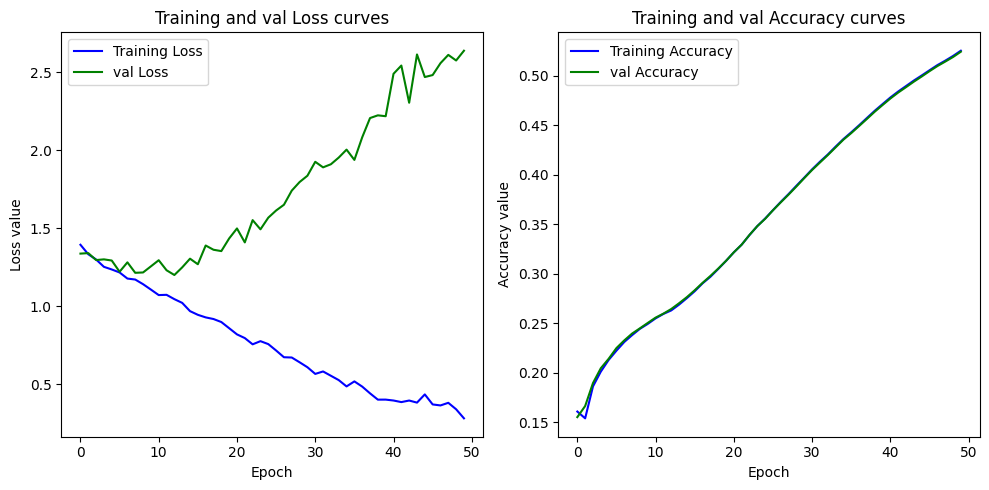

In [22]:
plot_results(results[0], results[1], results[2], results[3])

# Eval

In [23]:
model.load_state_dict(results[4])
test_loss, test_acc = evaluate(
    model.to(device), test_loader, criterion, metric, device
)

print(test_loss, test_acc)

2.560710867245992 0.5234176516532898
